In [40]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import random

### Modelo e Parâmetros

In [41]:
# Definição dos parâmetros
NUMBER_OF_ROUNDS = 100
TOTAL_CLIENTS = 100
CLIENTS_PER_ROUND = 10
LAMBDA = 0.60

In [42]:
class ModelMLP:
    @staticmethod
    def create_model():
        model = tf.keras.models.Sequential(
            [
                tf.keras.layers.Dense(units=128, activation='relu', input_shape=(784,)),
                tf.keras.layers.Dense(10, activation="softmax")
            ]
        )
        model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy']
        )
        return model

In [43]:
# Definição dos parâmetros
NUMBER_OF_ROUNDS = 100
TOTAL_CLIENTS = 100
CLIENTS_PER_ROUND = 10
LAMBDA = 0.30

### Cliente

In [44]:
class Client():
    def __init__(self, cid):
        self.cid = int(cid)
        self.model = ModelMLP.create_model()
        self.old_weights = None
        (self.x_train, self.y_train), (self.x_test, self.y_test) = self.load_data()


    def load_data(self):
        path = "../dataset-mnist/non-iid-0.9-100-rotation-45"

        train = pd.read_pickle(f"{path}/{self.cid+1}_train.pickle")
        test = pd.read_pickle(f"{path}/{self.cid+1}_test.pickle")

        x_train = train.drop(['label'], axis=1)
        y_train = train['label']

        x_test = test.drop(['label'], axis=1)
        y_test = test['label']

        return (x_train, y_train), (x_test, y_test)


    def fit(self, parameters, config=None):
        self.model.set_weights(parameters)
        history = self.model.fit(self.x_train, self.y_train, epochs=5, batch_size=128, validation_data=(self.x_test, self.y_test), verbose=False)
        sample_size = len(self.x_train)
        print(f"Acurácia: {history.history['val_accuracy'][-1]} | ", end='')

        if random.random() > LAMBDA and self.old_weights is not None:
            print("Modelo NÃO transmitido!")
            return None

        print('Modelo transmitido!')
        self.old_weights = self.model.get_weights()
        return self.model.get_weights(), sample_size, {"val_accuracy": history.history['val_accuracy'][-1], 
                                                       "val_loss": history.history['val_loss'][-1]}


    def evaluate(self, parameters):
        self.model.set_weights(parameters)
        return self.model.evaluate(self.x_test, self.y_test, verbose=False)

### Servidor

In [45]:
class Server():
    def __init__(self, n_rounds, total_number_clients, min_fit_clients):
        self.n_rounds = n_rounds
        self.total_number_clients = total_number_clients
        self.min_fit_clients = min_fit_clients

        self.server_round = 0
        self.selected_clients = []
        self.model = ModelMLP.create_model()
        self.w_global = self.model.get_weights()

        self.clients_model_list = []
        # Vamos guardar todos os modelos (pesos) anteriores, mas não é necessário
        self.clients_previous_models_list = [ [] for _ in range(total_number_clients) ]
        self.create_models()
        (self.x_train, self.y_train), (self.x_test, self.y_test) = self.load_data()


    def load_data(self):
        path = "../dataset-mnist/mnist"

        train = pd.read_pickle(f"{path}/train.pickle")
        test = pd.read_pickle(f"{path}/test.pickle")

        x_train = train.drop(['label'], axis=1)
        y_train = train['label']

        # test = pd.concat([test, train])
        x_test = test.drop(['label'], axis=1)
        y_test = test['label']

        return (x_train, y_train), (x_test, y_test)


    def create_models(self):
        for i in range(self.total_number_clients):
            self.clients_model_list.append(Client(i))


    def aggregate_fit(self, weight_list, sample_sizes):
        self.w_global = []
        for weights in zip(*weight_list):
            weighted_sum = 0
            total_samples = sum(sample_sizes)
            for i in range(len(weights)):
                weighted_sum += weights[i] * sample_sizes[i]
            self.w_global.append(weighted_sum / total_samples)


    def configure_fit(self):
        self.selected_clients = np.random.permutation(list(range(self.total_number_clients)))[:self.min_fit_clients]
        print(f"Clientes selecionados: \033[34;1m{np.array(self.selected_clients) + 1}\033[37;0m")

    
    def get_client_previous_model(self, client_id):
        return self.clients_previous_models_list[client_id][-1]


    def save_client_previous_model(self, client_id, model):
        self.clients_previous_models_list[client_id].append(model)


    def fit(self):
        weight_list, sample_sizes_list, info_list, transmissions_count = [], [], [], 0
        for i, pos in enumerate(self.selected_clients):
            print(f"Cliente #{pos+1} | ", end='')

            # Se o cliente decidir não enviar o modelo, ele retorna um None
            new_model = self.clients_model_list[pos].fit(parameters=self.w_global)

            weights, size, info = new_model if new_model is not None else self.get_client_previous_model(pos)
            weight_list.append(weights)
            sample_sizes_list.append(size)
            info_list.append(info)

            # Se o cliente enviou um novo modelo, salve-o e incremente a contagem de transmissões
            if new_model is not None:
                self.save_client_previous_model(pos, (weights, size, info_list))
                transmissions_count += 1

        return weight_list, sample_sizes_list, {"acc_loss_local":[(pos+1, info_list[i]) for i, pos in enumerate(self.selected_clients)]}, transmissions_count


    def distributed_evaluation(self):
        loss_list, accuracy_list = [], []
        for i in range(self.total_number_clients):
            loss, accuracy = self.clients_model_list[i].evaluate(parameters=self.w_global)
            # print(f"Evaluate - CID: {i+1} - accuracy: {accuracy}")
            loss_list.append(loss)
            accuracy_list.append(accuracy)
        return sum(loss_list) / len(loss_list), sum(accuracy_list) / len(accuracy_list), {"accuracy_list": [(i+1, accuracy) for i, accuracy in enumerate(accuracy_list)]}


    def centralized_evaluation(self):
        self.model.set_weights(self.w_global)
        return self.model.evaluate(self.x_test, self.y_test, verbose=False)

### Execução e Exibição

In [46]:
def executar(id):
    print('\n' + '='*40)
    print("{:^54}".format('\033[;1m' + 'CARREGAMENTO DE DADOS' + '\033[37;0m'))
    print("{:^40}".format(f'Número total de clientes: {TOTAL_CLIENTS}' + '\n'))
    
    s = Server(n_rounds=NUMBER_OF_ROUNDS,
               total_number_clients=TOTAL_CLIENTS,
               min_fit_clients=CLIENTS_PER_ROUND)
    
    print('\n' + '='*40)
    print("{:^54}".format('\033[;1m' + 'INICIANDO' + '\033[37;0m'))
    print("{:^40}".format(f'Clientes por rodada: {CLIENTS_PER_ROUND} ' + '\n'))
    
    evaluate_list = {"distributed": {"loss":[], "accuracy":[]}, "centralized": {"loss":[], "accuracy":[]}}
    
    transmissions_per_round = []
    
    # Rodadas de comunicação
    for s.server_round in range(s.n_rounds):
        print('\033[;1m' + f'Rodada {s.server_round+1}/{s.n_rounds}' + '\033[37;0m')
    
        # Seleciona os clientes que participarão da próxima rodada de comunicação
        s.configure_fit()
    
        # Treinamento local do dispositivo
        weight_list, sample_sizes, info, transmissions_count = s.fit()
    
        # Salva a quantidade de transmissões ocorridas nesta rodada
        transmissions_per_round.append(transmissions_count)
    
        # Agregação
        s.aggregate_fit(weight_list, sample_sizes)
    
        # Avaliação centralizada
        print('\033[3;1m' + '-'*40 + '\033[37;0m')
        # print(f"Avaliação centralizada")
        evaluate_loss, evaluate_accuracy = s.centralized_evaluation()
        print(f"Execução #{id}")
        print(f"Transmissões nesta rodada: {transmissions_count}")
        print(f"Acurácia: {evaluate_accuracy}")
        evaluate_list["centralized"]["loss"].append(evaluate_loss)
        evaluate_list["centralized"]["accuracy"].append(evaluate_accuracy)
        print('\033[3;1m' + '-'*40 + '\033[37;0m' + '\n')
    
    print('\n\n' + '='*40)
    print("{:^54}".format('\033[;1m' + 'RESULTADOS FINAIS' + '\033[37;0m'))
    print(f"\nCentralized loss: ", end='')
    print(evaluate_list["centralized"]["loss"])
    print(f"Centralized accuracy: ", end='')
    print(evaluate_list["centralized"]["accuracy"])

    return evaluate_list["centralized"]["accuracy"], evaluate_list["centralized"]["loss"], transmissions_per_round

In [47]:
def plotar_grafico_acuracia():
    fig, ax = plt.subplots(figsize=(3, 3))
    
    ax.set_ylabel('Acurácia', color='#000000', fontsize=12)
    ax.set_xlabel('Rodadas', color='#000000', fontsize=12)
    
    ax.set_ylim(auto=True)
    
    x1, y1 = [*range(len(acc_list[0]))], [np.mean(p) for p in zip(*acc_list)]
    ax.plot(x1, y1, linestyle = 'solid', color='#00aaff', linewidth = 1)
    y_min = [np.min(p) for p in zip(*acc_list)]
    y_max = [np.max(p) for p in zip(*acc_list)]
    ax.fill_between(x1, y_min, y_max, color='#00aaff', alpha=0.1)

In [48]:
def plotar_grafico_perda():
    fig, ax = plt.subplots(figsize=(3, 3))
    
    ax.set_ylabel('Perda', color='#000000', fontsize=12)
    ax.set_xlabel('Rodadas', color='#000000', fontsize=12)
    
    ax.set_ylim(auto=True)
    
    x1, y1 = [*range(len(loss_list[0]))], [np.mean(p) for p in zip(*loss_list)]
    ax.plot(x1, y1, linestyle = 'solid', color='#ff0000', linewidth = 1)
    y_min = [np.min(p) for p in zip(*loss_list)]
    y_max = [np.max(p) for p in zip(*loss_list)]
    ax.fill_between(x1, y_min, y_max, color='#ff0000', alpha=0.1)

In [49]:
def plotar_grafico_transmissoes():
    fig, ax = plt.subplots(figsize=(3, 3))
    
    ax.set_ylabel('Transmissões', color='#000000', fontsize=12)
    ax.set_xlabel('Rodadas', color='#000000', fontsize=12)
    
    ax.set_ylim(auto=True)
    
    x1, y1 = [*range(len(transmissions_list[0]))], [np.mean(p) for p in zip(*transmissions_list)]
    ax.plot(x1, y1, linestyle = 'solid', color='#44aa44', linewidth = 1)
    y_min = [np.min(p) for p in zip(*transmissions_list)]
    y_max = [np.max(p) for p in zip(*transmissions_list)]
    ax.fill_between(x1, y_min, y_max, color='#44aa44', alpha=0.1)

In [50]:
def plotar_grafico_transmissoes_acumuladas():
    acc_transmissions_list = [
        [np.sum(transmission_list[0:i]) for i in range(len(transmission_list))] 
        for transmission_list in transmissions_list
    ]
    
    fig, ax = plt.subplots(figsize=(3, 3))
    
    ax.set_ylabel('Transmissões Acumuladas', color='#000000', fontsize=12)
    ax.set_xlabel('Rodadas', color='#000000', fontsize=12)
    
    ax.set_ylim(auto=True)
    
    x1, y1 = [*range(len(acc_transmissions_list[0]))], [np.mean(p) for p in zip(*acc_transmissions_list)]
    ax.plot(x1, y1, linestyle = 'solid', color='#ffa500', linewidth = 1)
    y_min = [np.min(p) for p in zip(*acc_transmissions_list)]
    y_max = [np.max(p) for p in zip(*acc_transmissions_list)]
    ax.fill_between(x1, y_min, y_max, color='#ffa500', alpha=0.1)

In [51]:
def plotar_graficos():
    plotar_grafico_acuracia()
    plotar_grafico_perda()
    plotar_grafico_transmissoes()
    plotar_grafico_transmissoes_acumuladas()

### 1 - Validação de Epsilon = 40
Aproximadamente 300 transmissões

In [52]:
acc_list, loss_list, transmissions_list = [], [], []

for i in range(3):
    acc, loss, transmissions = executar(i)
    acc_list.append(acc)
    loss_list.append(loss)
    transmissions_list.append(transmissions)


          CARREGAMENTO DE DADOS           
     Número total de clientes: 100
     

                INICIANDO                 
       Clientes por rodada: 10 
        
Rodada 1/100
Clientes selecionados: [33 30 76 78 52 55 64 89 23 27]
Cliente #33 | Acurácia: 0.9070331454277039 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9041372537612915 | Modelo transmitido!
Cliente #76 | Acurácia: 0.8739902973175049 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9320755004882812 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9294294118881226 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9121114611625671 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9188332557678223 | Modelo transmitido!
Cliente #89 | Acurácia: 0.8707627058029175 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8757637739181519 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9226415157318115 | Modelo transmitido!
----------------------------------------
Execução #0
Transmissões nesta rodada: 10
Acurácia: 0.6055999994277954


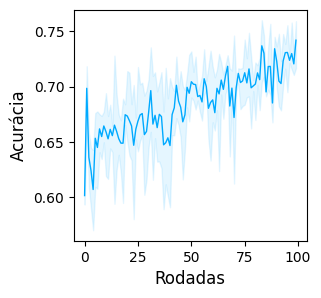

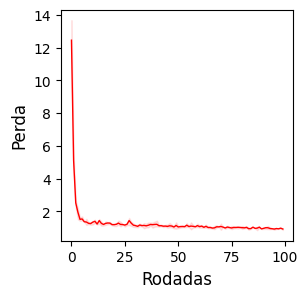

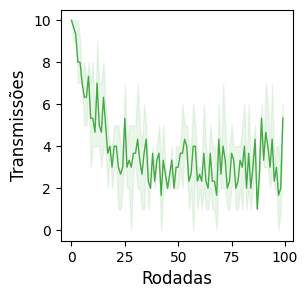

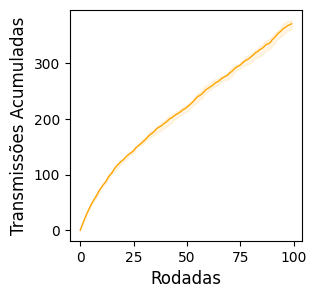

In [53]:
plotar_graficos()

### 2 - Validação de Epsilon = 25
Aproximadamente 440 transmissões

In [54]:
LAMBDA = 0.44

In [55]:
acc_list, loss_list, transmissions_list = [], [], []

for i in range(3):
    acc, loss, transmissions = executar(i)
    acc_list.append(acc)
    loss_list.append(loss)
    transmissions_list.append(transmissions)


          CARREGAMENTO DE DADOS           
     Número total de clientes: 100
     

                INICIANDO                 
       Clientes por rodada: 10 
        
Rodada 1/100
Clientes selecionados: [68 81  8 53 79 93 37 47 80 44]
Cliente #68 | Acurácia: 0.9304347634315491 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9341238737106323 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9063604474067688 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9202096462249756 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9128686189651489 | Modelo transmitido!
Cliente #93 | Acurácia: 0.8747390508651733 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9180633425712585 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9175475835800171 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9066073894500732 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9084561467170715 | Modelo transmitido!
----------------------------------------
Execução #0
Transmissões nesta rodada: 10
Acurácia: 0.5871000289916992
-

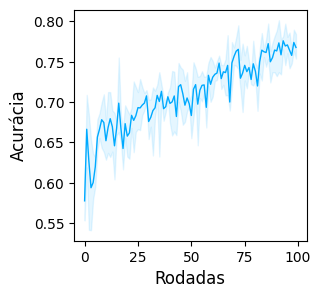

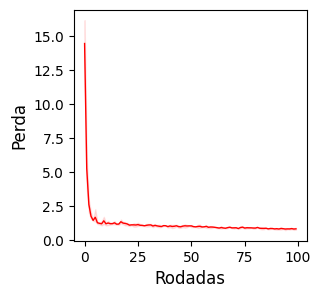

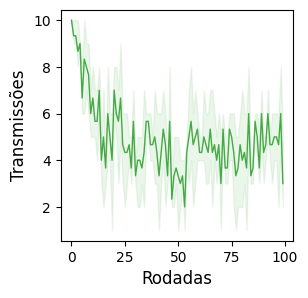

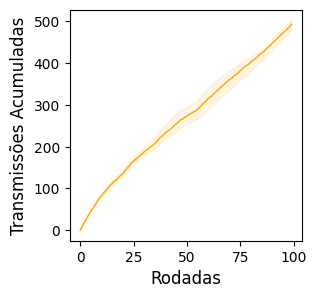

In [56]:
plotar_graficos()

### 3 - Validação de Epsilon = 55
Aproximadamente 250 transmissões

In [57]:
LAMBDA = 0.25

In [58]:
acc_list, loss_list, transmissions_list = [], [], []

for i in range(3):
    acc, loss, transmissions = executar(i)
    acc_list.append(acc)
    loss_list.append(loss)
    transmissions_list.append(transmissions)


          CARREGAMENTO DE DADOS           
     Número total de clientes: 100
     

                INICIANDO                 
       Clientes por rodada: 10 
        
Rodada 1/100
Clientes selecionados: [20 52 68 78 76 74  5 56 83 12]
Cliente #20 | Acurácia: 0.9208381772041321 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9189189076423645 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9207729697227478 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9320755004882812 | Modelo transmitido!
Cliente #76 | Acurácia: 0.8707593083381653 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9196786880493164 | Modelo transmitido!
Cliente #5 | Acurácia: 0.918749988079071 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8647618889808655 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9077844023704529 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9341517686843872 | Modelo transmitido!
----------------------------------------
Execução #0
Transmissões nesta rodada: 10
Acurácia: 0.6292999982833862
--

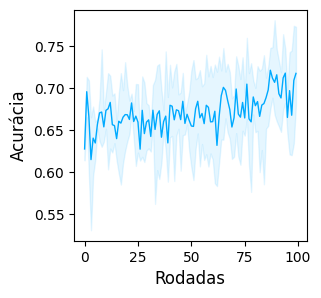

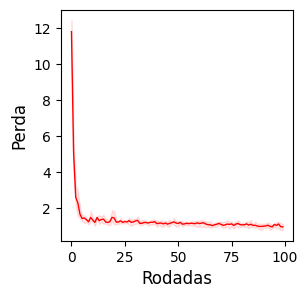

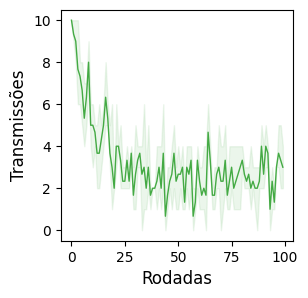

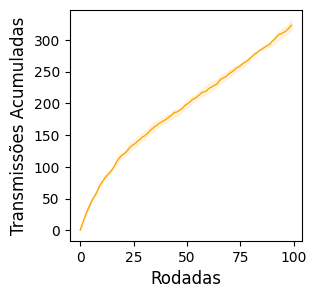

In [59]:
plotar_graficos()